# 데이터 불러오기
한국 기상청에서 제공하는 2015년 ~ 2022년 지진 데이터를 불러와서 적절히 파싱해 `DataFrame`객체로 만든다.

In [1]:
import urllib
import os

url = 'https://apihub.kma.go.kr/api/typ01/url/eqk_list.php?tm1=201506020103&tm2=202211231215&disp=0&help=1&authKey=vhBFrPBaSiWQRazwWlolWg'
path = os.path.join('datasets', 'earthquake.txt')

os.makedirs(os.path.join('datasets'), exist_ok=True)

urllib.request.urlretrieve(url, path)

('datasets/earthquake.txt', <http.client.HTTPMessage at 0x79b9f0e16b90>)

In [2]:
txt = open(path, 'r', encoding='cp949')

for _ in range(17):
    print(txt.readline())

data = []

header = txt.readline().split()[:7]
header[0] = 'TP'

while True:
    line = txt.readline()
    
    if not line:
        break
        
    if not line.split()[0].isnumeric():
        continue
        
    data.append(list(map(float, line.split()[:7])))
    
txt.close()

import pandas as pd

df = pd.DataFrame(data)
df.columns = header

df

#START7777

#--------------------------------------------------------------------------------------------------

#  지진정보  [입력인수형태][예] ?tm=201108070100&disp=1&help=1

#--------------------------------------------------------------------------------------------------

#  1. TP     : 3(국내지진통보), 2(국외지진정보)

#  2. TM_FC  : 발표시간

#  3. SEQ    : 발표일련번호

#  4. TM_EQK : 진앙시(년월일시분초)

#  5. MSC    : 진앙시(초 미만)

#  6. MT     : 규모

#  7. LAT    : 진앙 위도 (deg.)

#  8. LON    : 진앙 경도 (deg.)

#  9. LOC    : 진앙 위치

# 10. INT    : 진도

# 11. REM    : 참고사항

# 12. COR    : 수정사항

#--------------------------------------------------------------------------------------------------



,TP,TM_FC,SEQ,TM_EQK.MSC,MT,LAT,LON
0,3.0,2.015060e+11,65.0,2.015060e+13,2.0,36.76,129.98
1,2.0,2.015060e+11,66.0,2.015060e+13,6.0,27.90,140.90
2,2.0,2.015060e+11,67.0,2.015060e+13,5.0,43.50,144.10
3,2.0,2.015061e+11,68.0,2.015061e+13,6.0,6.08,116.55
4,2.0,2.015061e+11,68.0,2.015061e+13,6.0,6.08,116.55
...,...,...,...,...,...,...,...
1607,3.0,2.022112e+11,1154.0,2.022112e+13,3.3,33.96,125.22
1608,3.0,2.022112e+11,1157.0,2.022112e+13,2.0,41.29,129.22
1609,2.0,2.022112e+11,1162.0,2.022112e+13,7.3,-9.80,159.57
1610,2.0,2.022112e+11,1164.0,2.022112e+13,6.2,30.82,-116.44


# 목적 설정
이 모델의 목표는 시기, 위도, 경도 데이터를 종합해 지진이 발생한다면 진도가 어떻게 될지 예측하는 모델이다. 따라서 `MT`가 target이고 나머지가 feature이다.

# 데이터 정리 하기
- `TP`열은 국내 지진인지 해외 지진인지를 나타낸다. 예측과 관련없는 메타데이터이므로 제거한다.
- `SEQ`열은 발표 일련 번호이다. 마찬가지로 메타데이터이므로 제거한다.
- 한국 기상청에서 관측한 자료이므로 한국 근처의 데이터만 정확하다. 해외의 데이터는 진도 5이상의 강진만 정리되어 있다. 따라서, 한국 근처로 필터링한다.

In [3]:
df.drop(['TP', 'SEQ'], axis=1, inplace=True)

MIN_LON = 120
MAX_LON = 136
MIN_LAT = 30
MAX_LAT = 46

mask = (df['LON'] > MIN_LON) & (df['LON'] < MAX_LON) & (df['LAT'] > MIN_LAT) & (df['LAT'] < MAX_LAT)
df = df.loc[mask, :]

# 데이터 살펴보기
데이터를 살펴보며 결측치, 이상치 등을 체크한다.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866 entries, 0 to 1608
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TM_FC       866 non-null    float64
 1   TM_EQK.MSC  866 non-null    float64
 2   MT          866 non-null    float64
 3   LAT         866 non-null    float64
 4   LON         866 non-null    float64
dtypes: float64(5)
memory usage: 40.6 KB


In [5]:
df.describe()

,TM_FC,TM_EQK.MSC,MT,LAT,LON
count,8.660000e+02,8.660000e+02,866.000000,866.000000,866.000000
mean,2.018154e+11,2.018154e+13,2.642032,36.318668,127.971173
std,2.004856e+08,2.004856e+10,0.853507,1.942367,1.824261
min,2.015060e+11,2.015060e+13,2.000000,30.600000,121.190000
25%,2.017010e+11,2.017010e+13,2.125000,35.552500,126.307500
50%,2.017567e+11,2.017567e+13,2.400000,36.090000,128.365000
75%,2.020013e+11,2.020013e+13,2.700000,37.177500,129.340000
max,2.022112e+11,2.022112e+13,7.100000,45.270000,135.600000


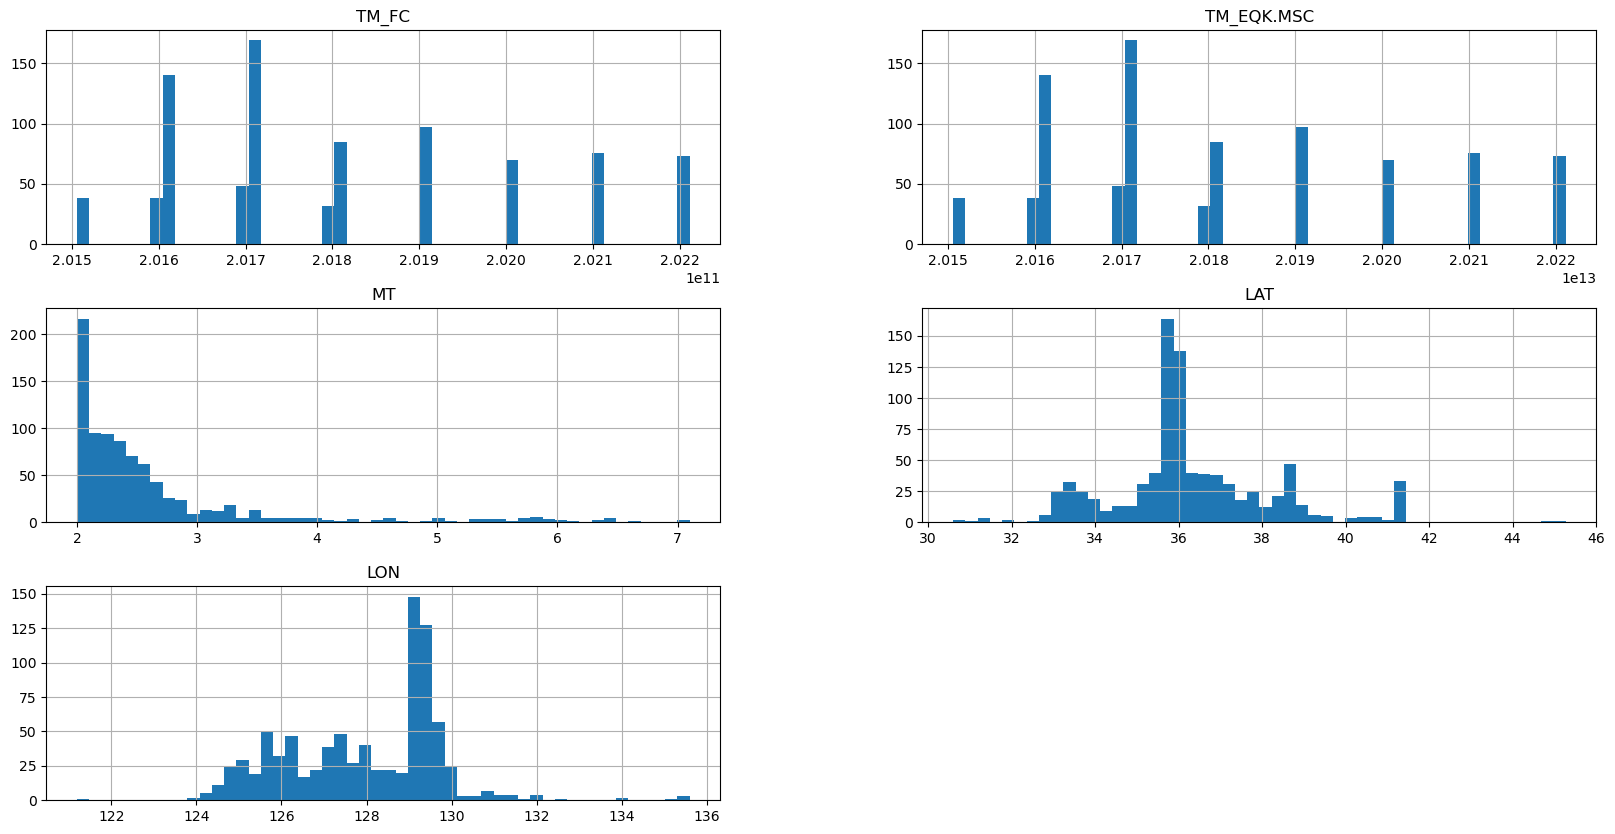

In [6]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20, 10))
plt.show()

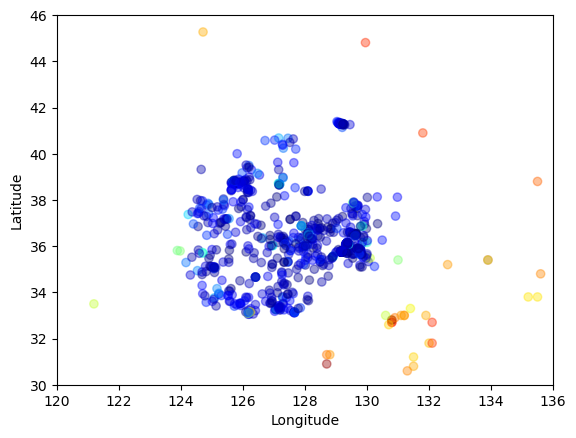

In [7]:
plt.xlim(MIN_LON, MAX_LON)
plt.ylim(MIN_LAT, MAX_LAT)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.scatter(
    df['LON'],
    df['LAT'],
    c = df['MT'],
    cmap = plt.get_cmap('jet'),
    alpha = 0.4
)

plt.show()

# ax = df.plot(
#     kind = 'scatter',
#     x = 'LON',
#     y = 'LAT',
#     alpha = 0.4,
#     c = df['MT'],
#     cmap = plt.get_cmap('jet'),
#     colorbar = True,
#     sharex = False
# )

# 상관계수 분석

In [8]:
corr_matrix = df.corr()
corr_matrix['MT'].sort_values(ascending=False)

MT            1.000000
LON           0.264675
TM_EQK.MSC   -0.063637
TM_FC        -0.063637
LAT          -0.158002
Name: MT, dtype: float64

array([[<Axes: xlabel='MT', ylabel='MT'>,
        <Axes: xlabel='TM_EQK.MSC', ylabel='MT'>,
        <Axes: xlabel='LON', ylabel='MT'>,
        <Axes: xlabel='LAT', ylabel='MT'>],
       [<Axes: xlabel='MT', ylabel='TM_EQK.MSC'>,
        <Axes: xlabel='TM_EQK.MSC', ylabel='TM_EQK.MSC'>,
        <Axes: xlabel='LON', ylabel='TM_EQK.MSC'>,
        <Axes: xlabel='LAT', ylabel='TM_EQK.MSC'>],
       [<Axes: xlabel='MT', ylabel='LON'>,
        <Axes: xlabel='TM_EQK.MSC', ylabel='LON'>,
        <Axes: xlabel='LON', ylabel='LON'>,
        <Axes: xlabel='LAT', ylabel='LON'>],
       [<Axes: xlabel='MT', ylabel='LAT'>,
        <Axes: xlabel='TM_EQK.MSC', ylabel='LAT'>,
        <Axes: xlabel='LON', ylabel='LAT'>,
        <Axes: xlabel='LAT', ylabel='LAT'>]], dtype=object)

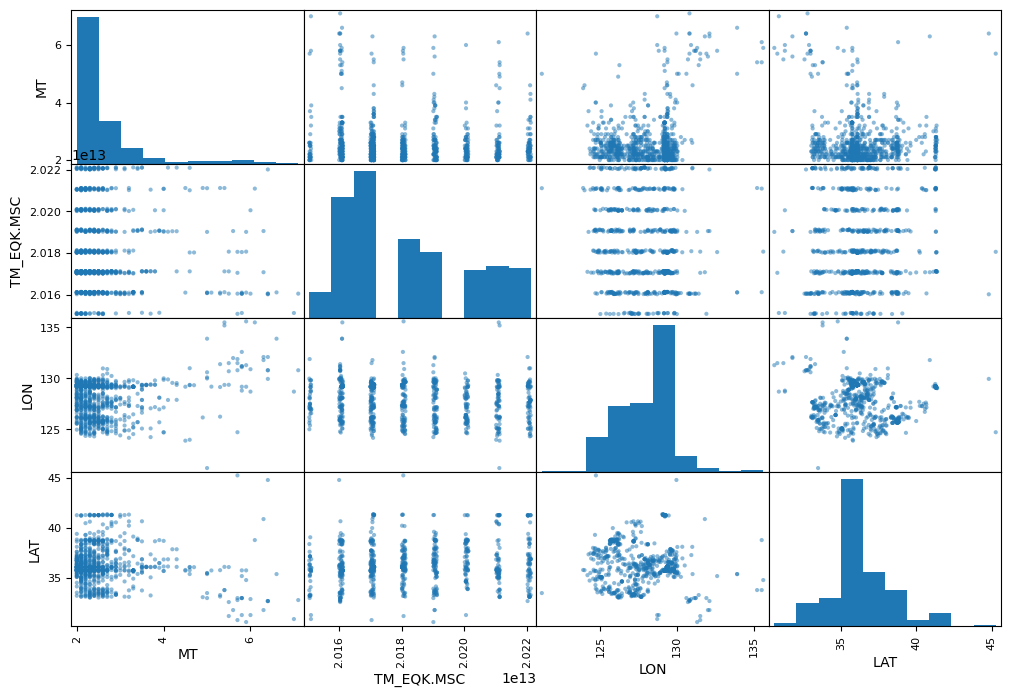

In [9]:
from pandas.plotting import scatter_matrix

attributes = [
    'MT',
    'TM_EQK.MSC',
    'LON',
    'LAT'
]

scatter_matrix(df[attributes], figsize = (12, 8))

# 데이터 정제하기
데이터를 정규화합니다.

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

labels = df['MT'].copy()
df.drop(['MT'], inplace=True, axis=1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

eq = num_pipeline.fit_transform(df)

eq

/tmp/ipykernel_20/2964339980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['MT'], inplace=True, axis=1)


array([[-1.5441956 , -1.54419505,  0.22734499,  1.10180901],
       [-1.5439363 , -1.54393577, -1.30775193, -0.98242942],
       [-1.543447  , -1.54344666,  1.07216343, -1.28958035],
       ...,
       [ 1.97509784,  1.97509827, -0.41142017, -1.98615477],
       [ 1.9751966 ,  1.97519703, -1.21502795, -1.50897387],
       [ 1.97520417,  1.97520412,  2.56089837,  0.68496132]])

# 모델 학습하기

선형회귀

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(eq, labels)

LinearRegression()

In [12]:
some_data = df.iloc[:5]
some_labels = labels.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)

print('예측:', lin_reg.predict(some_data_prepared))
print('레이블:', list(some_labels))

예측: [2.84716771 2.57957543 2.22648272 2.31046073 2.54741734]
레이블: [2.0, 2.6, 2.1, 2.6, 2.2]


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np

pred = lin_reg.predict(eq)
lin_mse = mean_squared_error(labels, pred)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

0.8140591657793887

In [14]:
def display_scores(scores):
    print('점수:', scores)
    print('평균:', scores.mean())
    print('표준편차:', scores.std())

In [15]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,
    eq,
    labels,
    scoring = 'neg_mean_squared_error',
    cv = 10
)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

점수: [1.36618505 0.92214326 0.56896123 0.77086268 0.66238655 0.80105019
 0.83657929 0.58413874 0.7653081  0.79485311]
평균: 0.8072468203736974
표준편차: 0.21384338424665694


결정 나무 회귀

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(eq, labels)

pred = tree_reg.predict(eq)
tree_mse = mean_squared_error(labels, pred)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.03948279948237407

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    tree_reg,
    eq,
    labels,
    scoring = 'neg_mean_squared_error',
    cv = 10
)

tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

점수: [1.33317528 1.0667385  0.45117981 0.65161162 1.84387772 0.678233
 0.78909722 0.86427816 0.50359175 0.93950754]
평균: 0.912129060024057
표준편차: 0.3986814949916505


랜덤 포레스트 회귀

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    return_train_score = True
)

grid_search.fit(eq, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [19]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.8415637281631057 {'max_features': 2, 'n_estimators': 3}
0.7245859115428835 {'max_features': 2, 'n_estimators': 10}
0.722493537520771 {'max_features': 2, 'n_estimators': 30}
0.7956784503489428 {'max_features': 4, 'n_estimators': 3}
0.6768981348605877 {'max_features': 4, 'n_estimators': 10}
0.7098139138968229 {'max_features': 4, 'n_estimators': 30}
0.7498622605612578 {'max_features': 6, 'n_estimators': 3}
0.6932441239953806 {'max_features': 6, 'n_estimators': 10}
0.6887364557591666 {'max_features': 6, 'n_estimators': 30}
0.7284476142715959 {'max_features': 8, 'n_estimators': 3}
0.763074038722448 {'max_features': 8, 'n_estimators': 10}
0.6764395912970739 {'max_features': 8, 'n_estimators': 30}
0.7875335713533791 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.7855356935401004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.7816623115259371 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.7782752921706402 {'bootstrap': False, 'max_features': 3, 'n_e

In [20]:
final_model = grid_search.best_estimator_

import joblib

joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']